In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Работа с air_reserve. Буду определять что за датасет, количество ненулевых и уникальных значений

### Общий план: импортирую датафреймы для air, привожу их к дням, где надо и потом объединяю. Чищу от аномалий, думаю над пропусками и тд

In [224]:
df_air_reserve = pd.read_csv('recruit-restaurant-visitor-forecasting/air_reserve.csv')
df_air_store_info = pd.read_csv('recruit-restaurant-visitor-forecasting/air_store_info.csv')
df_visit_data = pd.read_csv('recruit-restaurant-visitor-forecasting/air_visit_data.csv')
hpg_df = pd.read_csv('recruit-restaurant-visitor-forecasting/hpg_reserve.csv')
store_id_relation = pd.read_csv('recruit-restaurant-visitor-forecasting/store_id_relation.csv')
hpg_store = pd.read_csv('recruit-restaurant-visitor-forecasting/hpg_store_info.csv')
date_df = pd.read_csv('recruit-restaurant-visitor-forecasting/date_info.csv')

In [225]:
store_id_relation.shape


(150, 2)

In [226]:
print(date_df.shape)
date_df

(517, 3)


,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [227]:
store_id_relation.isnull().sum()

air_store_id    0
hpg_store_id    0
dtype: int64

### Нет пустых значений, значит можно не обрабатывать дополнительно

In [228]:
df_air_reserve.head(10)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
5,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 16:00:00,2
6,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 15:00:00,4
7,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-02 14:00:00,2
8,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-01 20:00:00,2
9,air_2b8b29ddfd35018e,2016-01-02 17:00:00,2016-01-02 17:00:00,2


### Для начала рассмотрим зависимость количества людей по дням, для этого сложу в первом даатафрейме количество зарезервировавшихся пользователей по дням

In [229]:
df_air_reserve['visit_datetime'] = pd.to_datetime(df_air_reserve['visit_datetime'])
df_air_reserve['reserve_datetime'] = pd.to_datetime(df_air_reserve['reserve_datetime'])
df_air_reserve['reserve_date'] = df_air_reserve['reserve_datetime'].dt.date
df_air_reserve['visit_date'] = df_air_reserve['visit_datetime'].dt.date

In [230]:
df_air_reserve = df_air_reserve.groupby(['air_store_id', 'visit_date', 'reserve_date'])[
    'reserve_visitors'].sum().reset_index()

In [231]:
air_df = pd.merge(df_air_reserve, df_air_store_info, on='air_store_id', how='outer')

In [232]:
air_df = pd.merge(air_df, df_visit_data, on=['air_store_id', 'visit_date'], how='outer')

In [233]:
air_df = pd.merge(air_df, store_id_relation, on=['air_store_id'], how='outer')

In [234]:
air_df = air_df[
    ['air_store_id', 'hpg_store_id', 'visit_date', 'visitors', 'reserve_visitors', 'air_genre_name', 'air_area_name',
     'latitude', 'longitude']]

In [235]:
air_df = air_df.rename(columns={'air_genre_name': 'genre_name', 'air_area_name': 'area_name'})


### Так как данные с пустым столбцом посетителей нам не нужны (это целевая переменная) удаляем их

In [236]:
air_df.dropna(subset='visitors', inplace=True)
air_df['visitors'] = air_df['visitors'].astype(int)

In [237]:
air_df.shape

(252108, 9)

### С первой системой данных выполнил объединение. Надо сделать аналогичное со вторым датасетом, но из-за того что в нем нет данных о целевой перменной буду только дополнять данные из первого датасета

In [238]:
hpg_df['visit_datetime'] = pd.to_datetime(hpg_df['visit_datetime'])
hpg_df['reserve_datetime'] = pd.to_datetime(hpg_df['reserve_datetime'])
hpg_df['reserve_date'] = hpg_df['reserve_datetime'].dt.date
hpg_df['visit_date'] = hpg_df['visit_datetime'].dt.date

In [239]:
hpg_df = hpg_df.groupby(['hpg_store_id', 'visit_date', 'reserve_date'])[
    'reserve_visitors'].sum().reset_index()

In [240]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [241]:
hpg_df = pd.merge(store_id_relation, hpg_df, on='hpg_store_id', how='outer')


In [242]:
hpg_df = pd.merge(hpg_df, hpg_store, on='hpg_store_id', how='outer')

In [243]:
hpg_df = hpg_df[
    ['air_store_id', 'hpg_store_id', 'visit_date', 'reserve_visitors', 'hpg_genre_name', 'hpg_area_name', 'latitude',
     'longitude']]

In [244]:
hpg_df = hpg_df.rename(columns={'hpg_genre_name': 'genre_name', 'hpg_area_name': 'area_name'})

### Объединил данные для второй системы


In [245]:
print(air_df.shape)
air_df.isnull().sum()

(252108, 9)


air_store_id             0
hpg_store_id        206089
visit_date               0
visitors                 0
reserve_visitors    252108
genre_name          252108
area_name           252108
latitude            252108
longitude           252108
dtype: int64

In [246]:
print(hpg_df.shape)
hpg_df.isnull().sum()

(1879302, 8)


air_store_id        1852770
hpg_store_id              0
visit_date                0
reserve_visitors          0
genre_name          1065690
area_name           1065690
latitude            1065690
longitude           1065690
dtype: int64

In [247]:
print(air_df.air_store_id.nunique(), hpg_df.air_store_id.nunique(), air_df.hpg_store_id.nunique(),
      hpg_df.hpg_store_id.nunique())

829 150 150 13325


In [248]:
df = pd.merge(air_df, hpg_df,
              on=['air_store_id', 'hpg_store_id', 'visit_date', 'reserve_visitors', 'area_name', 'genre_name',
                  'latitude', 'longitude'], how='outer')

In [249]:
df

,air_store_id,hpg_store_id,visit_date,visitors,reserve_visitors,genre_name,area_name,latitude,longitude
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-14,NaN,2.0,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-15,NaN,4.0,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-16,NaN,2.0,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-22,NaN,2.0,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-29,NaN,5.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2131405,NaN,hpg_fffc097dce87af3e,2017-03-10,NaN,2.0,NaN,NaN,NaN,NaN
2131406,NaN,hpg_fffc097dce87af3e,2017-03-17,NaN,2.0,NaN,NaN,NaN,NaN
2131407,NaN,hpg_fffc097dce87af3e,2017-03-27,NaN,5.0,NaN,NaN,NaN,NaN
2131408,NaN,hpg_fffc097dce87af3e,2017-04-21,NaN,3.0,NaN,NaN,NaN,NaN


In [250]:
print(df.shape)
df.isnull().sum()

(2131410, 9)


air_store_id        1852770
hpg_store_id         206089
visit_date                0
visitors            1879302
reserve_visitors     252108
genre_name          1317798
area_name           1317798
latitude            1317798
longitude           1317798
dtype: int64

In [251]:
# df = df.dropna(subset=['visitors', 'reserve_visitors'], how='any', inplace=True)

### Получается что нет таких строк, где одновременно присутствует и значения визиторс и брони. В этом можно убедиться запустив код выше => удаляю бронь
 

In [252]:
del df['reserve_visitors']
df

,air_store_id,hpg_store_id,visit_date,visitors,genre_name,area_name,latitude,longitude
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-14,NaN,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-15,NaN,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-16,NaN,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-22,NaN,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-29,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2131405,NaN,hpg_fffc097dce87af3e,2017-03-10,NaN,NaN,NaN,NaN,NaN
2131406,NaN,hpg_fffc097dce87af3e,2017-03-17,NaN,NaN,NaN,NaN,NaN
2131407,NaN,hpg_fffc097dce87af3e,2017-03-27,NaN,NaN,NaN,NaN,NaN
2131408,NaN,hpg_fffc097dce87af3e,2017-04-21,NaN,NaN,NaN,NaN,NaN


### Проверил данные по месяцам для тренировочной выборки, сейчас буду делать dataframe для столбцов с заполненной целевой переменной и буду дополнять его данными из други строк согласовано 

In [253]:
print(df.visit_date.unique)
df.columns

<bound method Series.unique of 0          2016-01-14
1          2016-01-15
2          2016-01-16
3          2016-01-22
4          2016-01-29
              ...    
2131405    2017-03-10
2131406    2017-03-17
2131407    2017-03-27
2131408    2017-04-21
2131409    2017-04-23
Name: visit_date, Length: 2131410, dtype: object>


Index(['air_store_id', 'hpg_store_id', 'visit_date', 'visitors', 'genre_name',
       'area_name', 'latitude', 'longitude'],
      dtype='object')

### Выполню дополнение данных для максимальной укомплектации достоверными данными строк, содержащих целевую переменную

In [254]:
df_full = df.dropna(subset=['visitors'])
print(df_full.shape)
df_full

(252108, 8)


,air_store_id,hpg_store_id,visit_date,visitors,genre_name,area_name,latitude,longitude
111,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-01,35.0,NaN,NaN,NaN,NaN
112,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-02,9.0,NaN,NaN,NaN,NaN
113,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-04,20.0,NaN,NaN,NaN,NaN
114,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-05,25.0,NaN,NaN,NaN,NaN
115,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-06,29.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
278635,air_fff68b929994bfbd,NaN,2017-04-18,6.0,NaN,NaN,NaN,NaN
278636,air_fff68b929994bfbd,NaN,2017-04-19,2.0,NaN,NaN,NaN,NaN
278637,air_fff68b929994bfbd,NaN,2017-04-20,2.0,NaN,NaN,NaN,NaN
278638,air_fff68b929994bfbd,NaN,2017-04-21,4.0,NaN,NaN,NaN,NaN


In [255]:
df_missing = df[df['visitors'].isna()]
print(df_missing.shape)
df_missing

(1879302, 8)


,air_store_id,hpg_store_id,visit_date,visitors,genre_name,area_name,latitude,longitude
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-14,NaN,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-15,NaN,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-16,NaN,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-22,NaN,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-29,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2131405,NaN,hpg_fffc097dce87af3e,2017-03-10,NaN,NaN,NaN,NaN,NaN
2131406,NaN,hpg_fffc097dce87af3e,2017-03-17,NaN,NaN,NaN,NaN,NaN
2131407,NaN,hpg_fffc097dce87af3e,2017-03-27,NaN,NaN,NaN,NaN,NaN
2131408,NaN,hpg_fffc097dce87af3e,2017-04-21,NaN,NaN,NaN,NaN,NaN


In [256]:
df_result_air = df_full.set_index(['air_store_id', 'visit_date']).combine_first(
    df_missing.set_index(['air_store_id', 'visit_date'])
).reset_index()
# Объединяем по hpg_store_id и visit_date
df_result_hpg = df_full.set_index(['hpg_store_id', 'visit_date']).combine_first(
    df_missing.set_index(['hpg_store_id', 'visit_date'])
).reset_index()

# Объединяем результаты двух объединений
df_result = pd.concat([df_result_air, df_result_hpg]).drop_duplicates()

# Оставляем только строки с заполненным visitors
df_result = df_result[df_result['visitors'].notna()]

# Удаляем дубликаты, если они есть
df_result = df_result.drop_duplicates()
print(df_result.shape)
df = df_result
df['visitors'] = df['visitors'].astype(int)
df

(252108, 8)


,air_store_id,visit_date,hpg_store_id,visitors,genre_name,area_name,latitude,longitude
111,air_00a91d42b08b08d9,2016-07-01,hpg_fbe603376b5980fc,35,NaN,NaN,NaN,NaN
112,air_00a91d42b08b08d9,2016-07-02,hpg_fbe603376b5980fc,9,NaN,NaN,NaN,NaN
113,air_00a91d42b08b08d9,2016-07-04,hpg_fbe603376b5980fc,20,NaN,NaN,NaN,NaN
114,air_00a91d42b08b08d9,2016-07-05,hpg_fbe603376b5980fc,25,NaN,NaN,NaN,NaN
115,air_00a91d42b08b08d9,2016-07-06,hpg_fbe603376b5980fc,29,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
278635,air_fff68b929994bfbd,2017-04-18,NaN,6,NaN,NaN,NaN,NaN
278636,air_fff68b929994bfbd,2017-04-19,NaN,2,NaN,NaN,NaN,NaN
278637,air_fff68b929994bfbd,2017-04-20,NaN,2,NaN,NaN,NaN,NaN
278638,air_fff68b929994bfbd,2017-04-21,NaN,4,NaN,NaN,NaN,NaN


### Датасеты объединены и доплнены. Теперь надо анализировать данные на наличие аномалий




In [257]:
date_df = date_df.rename(columns={'calendar_date': 'visit_date'})

In [258]:
date_df

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [259]:
df = pd.merge(df, date_df, on='visit_date', how='outer')
print(df.shape)

(252147, 10)


In [260]:
df = df.dropna(subset=['visitors'])
print(df.shape)

(252108, 10)


In [261]:
del df['latitude']
del df['longitude']
del df['hpg_store_id']
df

,air_store_id,visit_date,visitors,genre_name,area_name,day_of_week,holiday_flg
0,air_04341b588bde96cd,2016-01-01,10.0,NaN,NaN,Friday,1
1,air_05c325d315cc17f5,2016-01-01,29.0,NaN,NaN,Friday,1
2,air_08ba8cd01b3ba010,2016-01-01,11.0,NaN,NaN,Friday,1
3,air_09a845d5b5944b01,2016-01-01,56.0,NaN,NaN,Friday,1
4,air_1f7f8fa557bc0d55,2016-01-01,6.0,NaN,NaN,Friday,1
...,...,...,...,...,...,...,...
252103,air_fea5dc9594450608,2017-04-22,14.0,NaN,NaN,Saturday,0
252104,air_fee8dcf4d619598e,2017-04-22,53.0,NaN,NaN,Saturday,0
252105,air_fef9ccb3ba0da2f7,2017-04-22,5.0,NaN,NaN,Saturday,0
252106,air_ffcc2d5087e1b476,2017-04-22,1.0,NaN,NaN,Saturday,0


In [262]:
print(df.columns)

Index(['air_store_id', 'visit_date', 'visitors', 'genre_name', 'area_name',
       'day_of_week', 'holiday_flg'],
      dtype='object')


 ### Добавил столбец с днями недели и праздниками. Начинаю обработку

In [263]:
print(df.air_store_id.nunique())
df.air_store_id.unique()

829


array(['air_04341b588bde96cd', 'air_05c325d315cc17f5',
       'air_08ba8cd01b3ba010', 'air_09a845d5b5944b01',
       'air_1f7f8fa557bc0d55', 'air_2570ccb93badde68',
       'air_25d8e5cc57dd87d9', 'air_298513175efdf261',
       'air_35c4732dcbfe31be', 'air_36bcf77d3382d36e',
       'air_39dccf7df20b1c6a', 'air_3b6438b125086430',
       'air_506fe758114df773', 'air_536043fcf1a4f8a4',
       'air_57ed725a1930a5b9', 'air_5b6d18c470bbfaf9',
       'air_5c65468938c07fa5', 'air_60a7057184ec7ec7',
       'air_6e3fd96320d24324', 'air_70e9e8cd55879414',
       'air_71903025d39a4571', 'air_79f528087f49df06',
       'air_7cc17a324ae5c7dc', 'air_81c5dff692063446',
       'air_877f79706adbfb06', 'air_87f9e1024b951f01',
       'air_883ca28ef0ed3d55', 'air_8d50c64692322dff',
       'air_9d452a881f7f2bb7', 'air_a083834e7ffe187e',
       'air_b2d8bc9c88b85f96', 'air_c31472d14e29cee8',
       'air_c92745dfdd2ec68a', 'air_cb7467aed805e7fe',
       'air_cfdeb326418194ff', 'air_d0a1e69685259c92',
       'ai

In [264]:
df.info

<bound method DataFrame.info of                 air_store_id  visit_date  visitors genre_name area_name  \
0       air_04341b588bde96cd  2016-01-01      10.0        NaN       NaN   
1       air_05c325d315cc17f5  2016-01-01      29.0        NaN       NaN   
2       air_08ba8cd01b3ba010  2016-01-01      11.0        NaN       NaN   
3       air_09a845d5b5944b01  2016-01-01      56.0        NaN       NaN   
4       air_1f7f8fa557bc0d55  2016-01-01       6.0        NaN       NaN   
...                      ...         ...       ...        ...       ...   
252103  air_fea5dc9594450608  2017-04-22      14.0        NaN       NaN   
252104  air_fee8dcf4d619598e  2017-04-22      53.0        NaN       NaN   
252105  air_fef9ccb3ba0da2f7  2017-04-22       5.0        NaN       NaN   
252106  air_ffcc2d5087e1b476  2017-04-22       1.0        NaN       NaN   
252107  air_fff68b929994bfbd  2017-04-22       5.0        NaN       NaN   

       day_of_week  holiday_flg  
0           Friday            1  

In [265]:
df.describe()

,visitors,holiday_flg
count,252108.000000,252108.000000
mean,20.973761,0.050673
std,16.757007,0.219329
min,1.000000,0.000000
25%,9.000000,0.000000
50%,17.000000,0.000000
75%,29.000000,0.000000
max,877.000000,1.000000


In [266]:
print(df.shape, df.air_store_id.notna().sum(), df.air_store_id.nunique())

(252108, 7) 252108 829


In [267]:
df['visitors'] = df['visitors'].astype(int)
df

,air_store_id,visit_date,visitors,genre_name,area_name,day_of_week,holiday_flg
0,air_04341b588bde96cd,2016-01-01,10,NaN,NaN,Friday,1
1,air_05c325d315cc17f5,2016-01-01,29,NaN,NaN,Friday,1
2,air_08ba8cd01b3ba010,2016-01-01,11,NaN,NaN,Friday,1
3,air_09a845d5b5944b01,2016-01-01,56,NaN,NaN,Friday,1
4,air_1f7f8fa557bc0d55,2016-01-01,6,NaN,NaN,Friday,1
...,...,...,...,...,...,...,...
252103,air_fea5dc9594450608,2017-04-22,14,NaN,NaN,Saturday,0
252104,air_fee8dcf4d619598e,2017-04-22,53,NaN,NaN,Saturday,0
252105,air_fef9ccb3ba0da2f7,2017-04-22,5,NaN,NaN,Saturday,0
252106,air_ffcc2d5087e1b476,2017-04-22,1,NaN,NaN,Saturday,0


In [268]:
maximum_visitors_index = df['visitors'].idxmax()
id_for_max = df.loc[maximum_visitors_index, 'air_store_id']
print(f"Значение столбца 'id' для строки с максимальным значением 'visitors': {id_for_max}")
# print(df['visitors'].max())
matching_visitors = df.loc[df['air_store_id'] == id_for_max, 'visitors']
matching_times = df.loc[df['air_store_id'] == id_for_max, 'visit_date']
print("Значения столбца 'visitors' для соответствующих строк:")
matching_visitors.describe()
#TODO сделать так для всех ресторанов

Значение столбца 'id' для строки с максимальным значением 'visitors': air_cfdeb326418194ff
Значения столбца 'visitors' для соответствующих строк:


count    407.000000
mean      17.090909
std       43.817288
min        1.000000
25%        6.000000
50%       15.000000
75%       22.000000
max      877.000000
Name: visitors, dtype: float64

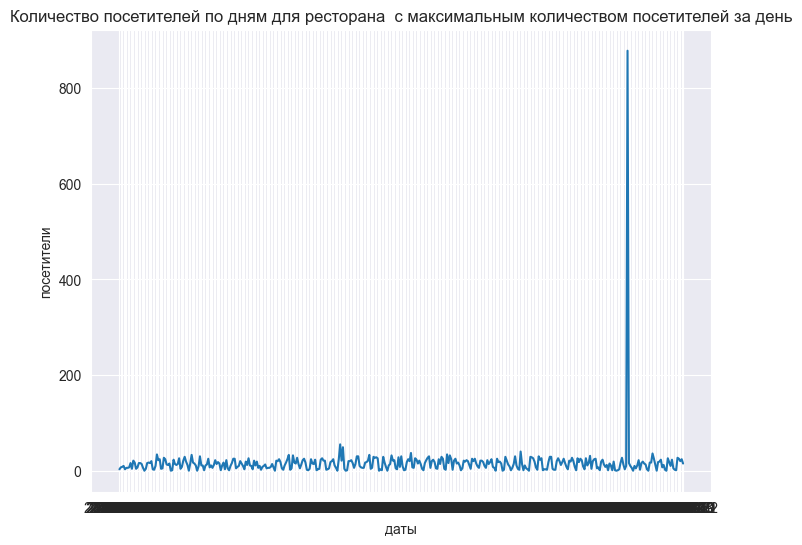

In [269]:
plt.figure(figsize=(8, 6))
plt.plot(matching_times, matching_visitors)
plt.xlabel('даты')
plt.ylabel('посетители')
plt.title('Количество посетителей по дням для ресторана  с максимальным количеством посетителей за день')
plt.show()

### тут это очевидный выброс, поэтому это нужно удалить будет для всех ресторанов в отдельности


In [270]:
result_df = pd.DataFrame()

for id in df['air_store_id'].unique():
    subset = df[df['air_store_id'] == id]
    mean_visitors = subset['visitors'].mean()
    std_visitors = subset['visitors'].std()
    mask = subset['visitors'] <= (mean_visitors + std_visitors)
    filtered_subset = subset[mask]
    result_df = pd.concat([result_df, filtered_subset])
    print(id, 'информация  для этого ресторана', filtered_subset['visitors'].describe())


air_04341b588bde96cd информация  для этого ресторана count    392.000000
mean      30.706633
std       11.761185
min        1.000000
25%       23.000000
50%       31.000000
75%       40.000000
max       52.000000
Name: visitors, dtype: float64
air_05c325d315cc17f5 информация  для этого ресторана count    396.000000
mean      19.747475
std        6.774626
min        1.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       31.000000
Name: visitors, dtype: float64
air_08ba8cd01b3ba010 информация  для этого ресторана count    382.000000
mean       8.709424
std        3.845694
min        1.000000
25%        6.000000
50%        9.000000
75%       12.000000
max       15.000000
Name: visitors, dtype: float64
air_09a845d5b5944b01 информация  для этого ресторана count    356.000000
mean       8.227528
std        4.863943
min        1.000000
25%        4.000000
50%        8.000000
75%       11.000000
max       22.000000
Name: visitors, dtype: float64
air_1f7f8fa557bc0d55 инф

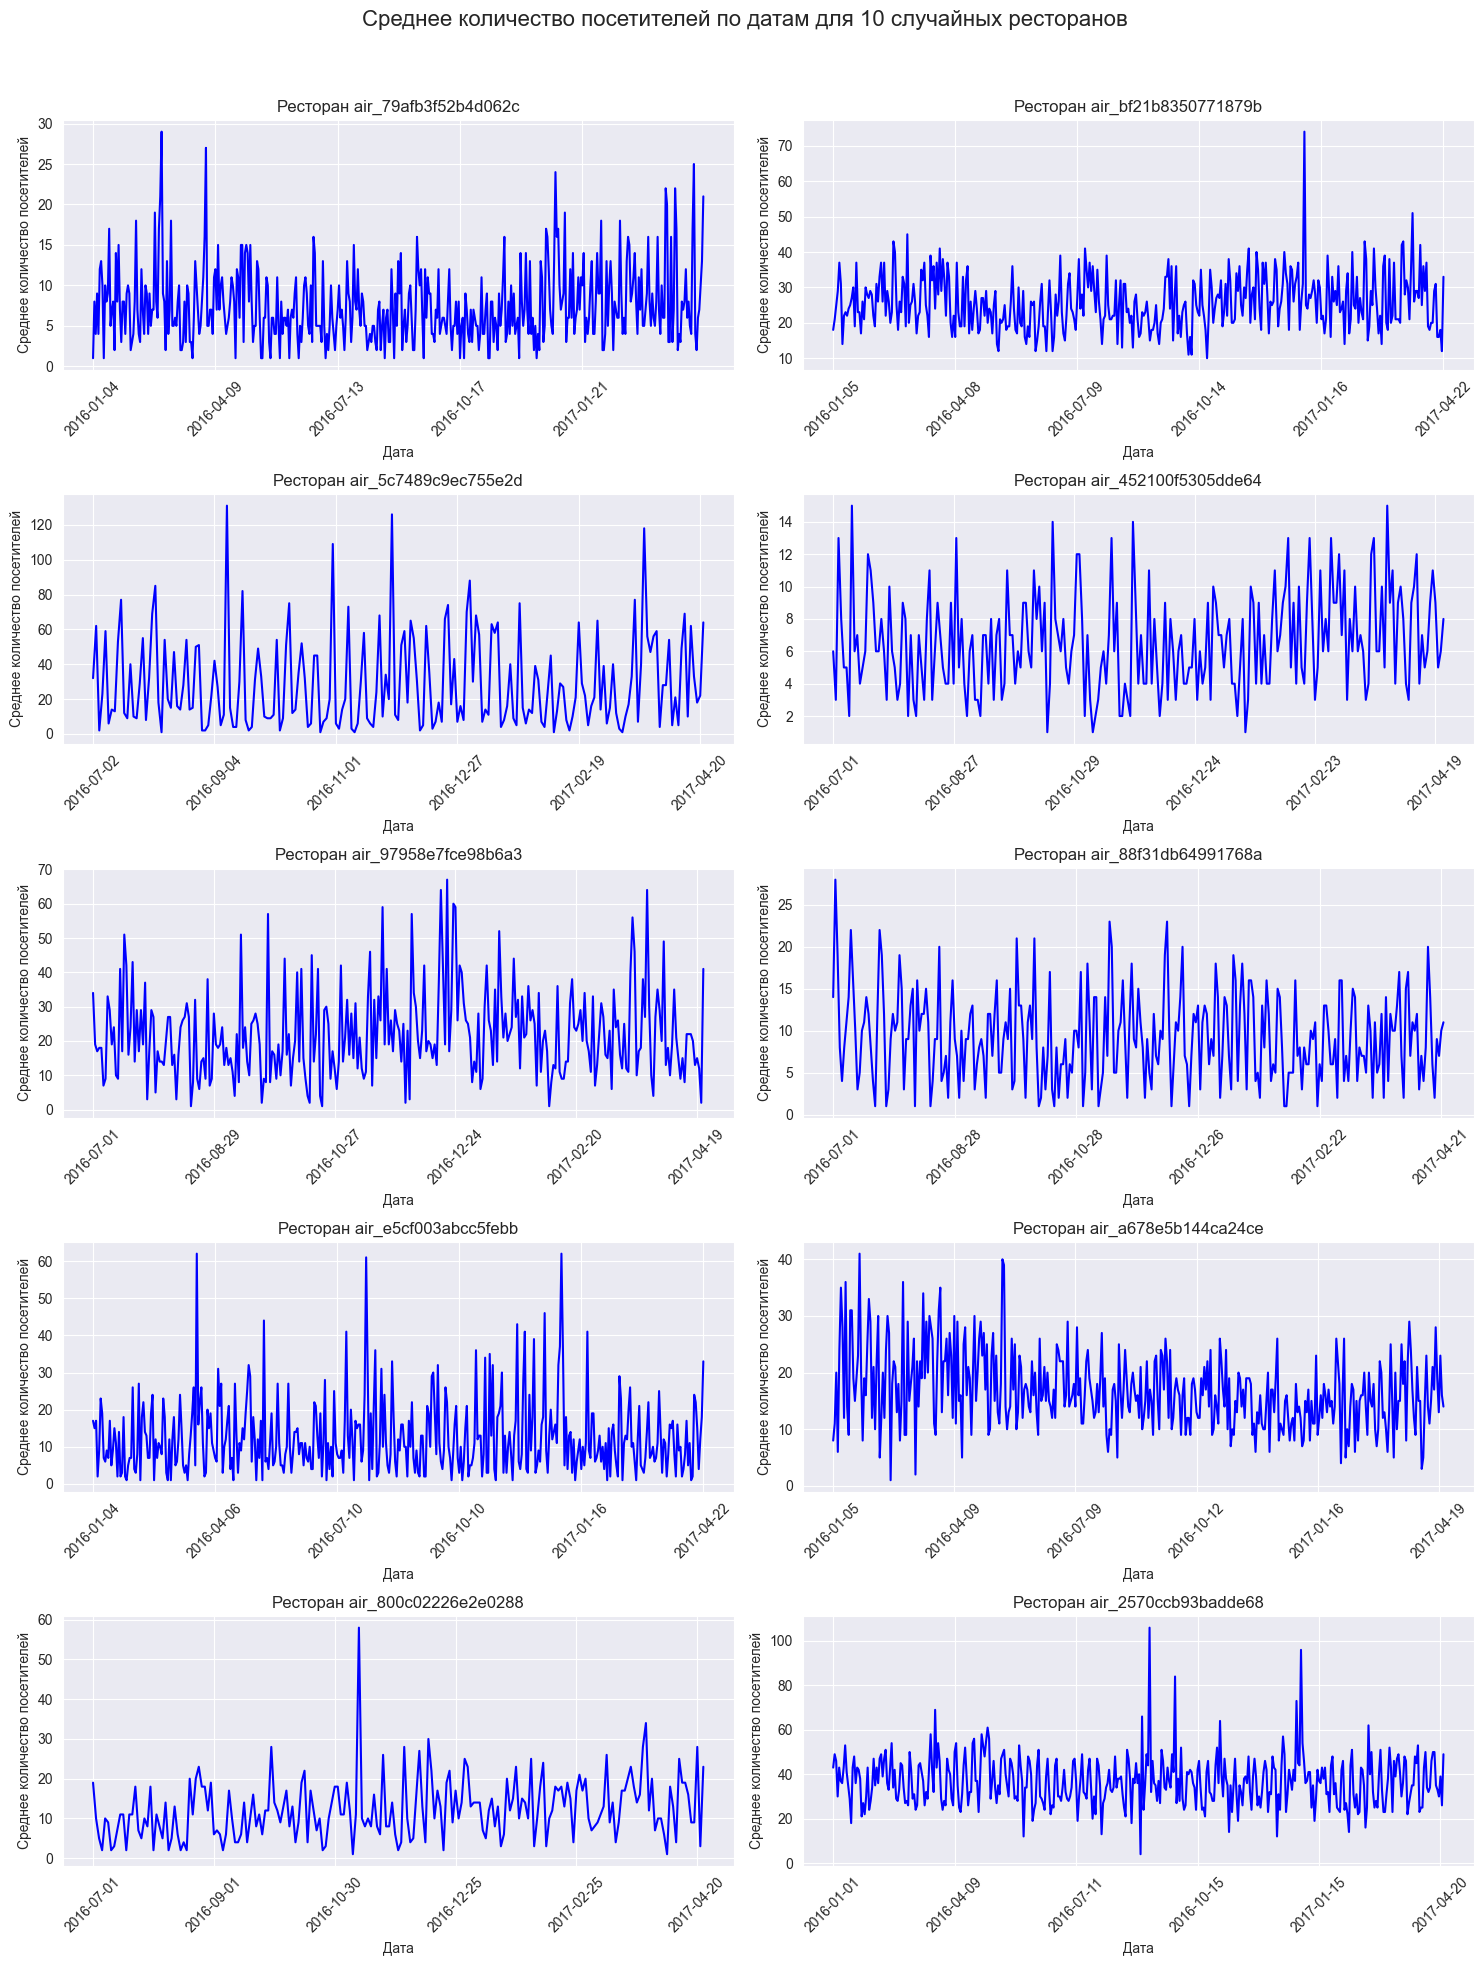

In [271]:
import random

np.random.seed(0)
random_restaurants = random.sample(df['air_store_id'].unique().tolist(), 10)
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Среднее количество посетителей по датам для 10 случайных ресторанов', fontsize=16)
axes = axes.flatten()

for i, restaurant_id in enumerate(random_restaurants):
    ax = axes[i]
    restaurant_data = df[df['air_store_id'] == restaurant_id]
    mean_visitors_by_date = restaurant_data.groupby('visit_date')['visitors'].mean()
    ax.plot(mean_visitors_by_date.index, mean_visitors_by_date.values, color='blue')
    ax.set_title(f'Ресторан {restaurant_id}')
    ax.set_ylabel('Среднее количество посетителей')
    ax.set_xlabel('Дата')
    ax.tick_params(axis='x', rotation=45)

    # Выбираем только часть дат для отображения
    dates = mean_visitors_by_date.index
    ax.set_xticks(dates[::len(dates) // 5])  # Выбираем каждую 5-ю дату для отображения

for i in range(len(random_restaurants), 10):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Это я вывел, чтобы убедиться, что разные рестораны по-разному людей завлекают :)

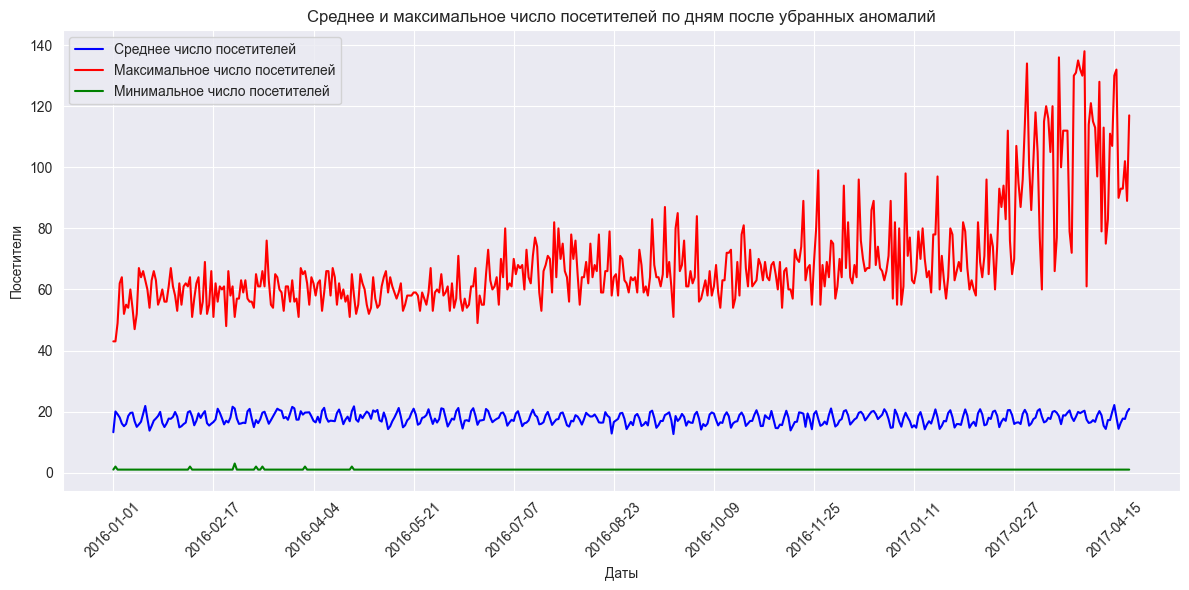

In [272]:
# Вычисляем среднее и максимальное число посетителей по датам
mean_visitors_by_date = result_df.groupby('visit_date')['visitors'].mean()
max_visitors_by_date = result_df.groupby('visit_date')['visitors'].max()
min_visitors_by_date = result_df.groupby('visit_date')['visitors'].min()

# Создаем график
plt.figure(figsize=(12, 6))
plt.plot(mean_visitors_by_date.index, mean_visitors_by_date.values, label='Среднее число посетителей', color='blue')
plt.plot(max_visitors_by_date.index, max_visitors_by_date.values, label='Максимальное число посетителей', color='red')
plt.plot(min_visitors_by_date.index, min_visitors_by_date.values, label='Минимальное число посетителей', color='green')
plt.xlabel('Даты')
plt.title('Среднее и максимальное число посетителей по дням после убранных аномалий')
plt.ylabel('Посетители')
plt.title('Среднее и максимальное число посетителей по дням после убранных аномалий')
plt.legend()
plt.grid(True)
dates = mean_visitors_by_date.index.values
plt.xticks(dates[::len(dates) // 10], rotation=45)  # Выбираем каждую 10-ю дату для отображения
plt.tight_layout()
plt.show()

In [273]:
df = result_df
print(df.shape)

(214996, 7)


Почистил значения по посетителям, теперь значения не отрицательные и нет вбросов


In [274]:
cols = df.columns
for col in cols:
    print(f"Характеристика: {col}")
    print("Количество уникальных значений:", {df[col].nunique()})
    print('///////////////////////////////////////////////////')

Характеристика: air_store_id
Количество уникальных значений: {829}
///////////////////////////////////////////////////
Характеристика: visit_date
Количество уникальных значений: {478}
///////////////////////////////////////////////////
Характеристика: visitors
Количество уникальных значений: {124}
///////////////////////////////////////////////////
Характеристика: genre_name
Количество уникальных значений: {0}
///////////////////////////////////////////////////
Характеристика: area_name
Количество уникальных значений: {0}
///////////////////////////////////////////////////
Характеристика: day_of_week
Количество уникальных значений: {7}
///////////////////////////////////////////////////
Характеристика: holiday_flg
Количество уникальных значений: {2}
///////////////////////////////////////////////////


In [275]:
# Количество полностью заполненных строк
fully_filled_rows = df.dropna().shape[0]
total_rows = df.shape[0]
print(f'Количество полностью заполненных строк - {fully_filled_rows}')
print(f'Их процент из всей выборки - {int(fully_filled_rows / total_rows * 100)}%')

# Получение количества заполненных строк, ненулевых и уникальных значений для каждого столбца
for column in df.columns:
    non_null_count = df[column].count()
    non_zero_count = df[column].astype(bool).sum()
    unique_count = df[column].nunique()

    print(f'\nСтолбец: {column}')
    print(f'Количество заполненных строк: {non_null_count}')
    print(f'Количество ненулевых значений: {non_zero_count}')
    print(f'Количество уникальных значений: {unique_count}')
    print(f'Процент ненулевых значений: {non_zero_count / total_rows * 100:.2f}%')
    print(f'Процент уникальных значений: {unique_count / total_rows * 100:.2f}%')

Количество полностью заполненных строк - 0
Их процент из всей выборки - 0%

Столбец: air_store_id
Количество заполненных строк: 214996
Количество ненулевых значений: 214996
Количество уникальных значений: 829
Процент ненулевых значений: 100.00%
Процент уникальных значений: 0.39%

Столбец: visit_date
Количество заполненных строк: 214996
Количество ненулевых значений: 214996
Количество уникальных значений: 478
Процент ненулевых значений: 100.00%
Процент уникальных значений: 0.22%

Столбец: visitors
Количество заполненных строк: 214996
Количество ненулевых значений: 214996
Количество уникальных значений: 124
Процент ненулевых значений: 100.00%
Процент уникальных значений: 0.06%

Столбец: genre_name
Количество заполненных строк: 0
Количество ненулевых значений: 214996
Количество уникальных значений: 0
Процент ненулевых значений: 100.00%
Процент уникальных значений: 0.00%

Столбец: area_name
Количество заполненных строк: 0
Количество ненулевых значений: 214996
Количество уникальных значений

### Исходя из этого результата видим, что не нужны столбцы area_name и genre_name
Дополнять пропуски негде


In [276]:
del df['area_name'], df['genre_name']

In [277]:
cols = df.columns
for col in cols:
    print(f"Характеристика: {col}")
    print("Количество уникальных значений:", {df[col].nunique()})
    print('///////////////////////////////////////////////////')

Характеристика: air_store_id
Количество уникальных значений: {829}
///////////////////////////////////////////////////
Характеристика: visit_date
Количество уникальных значений: {478}
///////////////////////////////////////////////////
Характеристика: visitors
Количество уникальных значений: {124}
///////////////////////////////////////////////////
Характеристика: day_of_week
Количество уникальных значений: {7}
///////////////////////////////////////////////////
Характеристика: holiday_flg
Количество уникальных значений: {2}
///////////////////////////////////////////////////


In [278]:
# Количество полностью заполненных строк
fully_filled_rows = df.dropna().shape[0]
total_rows = df.shape[0]
print(f'Количество полностью заполненных строк - {fully_filled_rows}')
print(f'Их процент из всей выборки - {int(fully_filled_rows / total_rows * 100)}%')

# Получение количества заполненных строк, ненулевых и уникальных значений для каждого столбца
for column in df.columns:
    non_null_count = df[column].count()
    non_zero_count = df[column].astype(bool).sum()
    unique_count = df[column].nunique()

    print(f'\nСтолбец: {column}')
    print(f'Количество заполненных строк: {non_null_count}')
    print(f'Количество ненулевых значений: {non_zero_count}')
    print(f'Количество уникальных значений: {unique_count}')
    print(f'Процент ненулевых значений: {non_zero_count / total_rows * 100:.2f}%')
    print(f'Процент уникальных значений: {unique_count / total_rows * 100:.2f}%')

Количество полностью заполненных строк - 214996
Их процент из всей выборки - 100%

Столбец: air_store_id
Количество заполненных строк: 214996
Количество ненулевых значений: 214996
Количество уникальных значений: 829
Процент ненулевых значений: 100.00%
Процент уникальных значений: 0.39%

Столбец: visit_date
Количество заполненных строк: 214996
Количество ненулевых значений: 214996
Количество уникальных значений: 478
Процент ненулевых значений: 100.00%
Процент уникальных значений: 0.22%

Столбец: visitors
Количество заполненных строк: 214996
Количество ненулевых значений: 214996
Количество уникальных значений: 124
Процент ненулевых значений: 100.00%
Процент уникальных значений: 0.06%

Столбец: day_of_week
Количество заполненных строк: 214996
Количество ненулевых значений: 214996
Количество уникальных значений: 7
Процент ненулевых значений: 100.00%
Процент уникальных значений: 0.00%

Столбец: holiday_flg
Количество заполненных строк: 214996
Количество ненулевых значений: 10008
Количество 

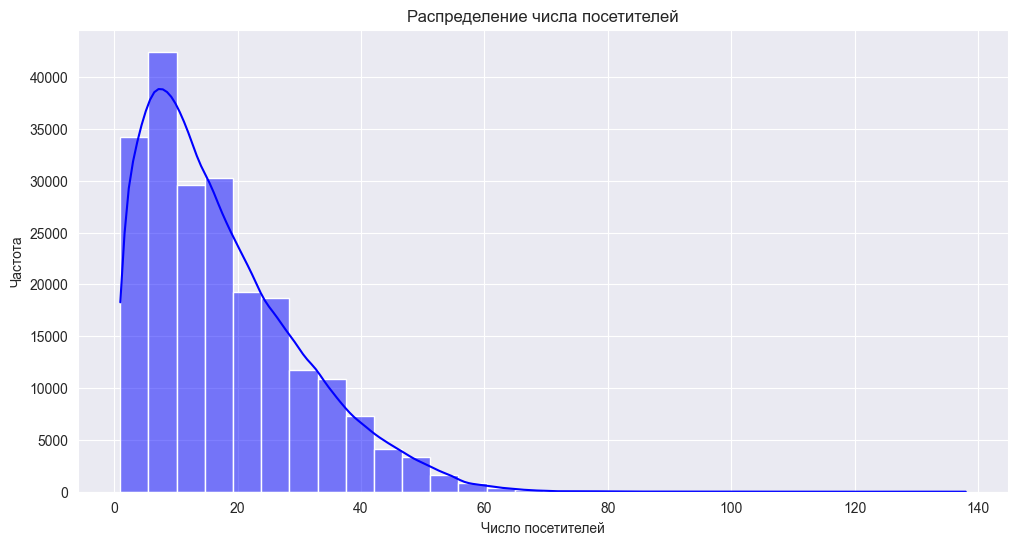

In [279]:
# Анализ данных с графиками

# 1. Распределение числа посетителей
plt.figure(figsize=(12, 6))
sns.histplot(df['visitors'], bins=30, kde=True, color='blue')
plt.title('Распределение числа посетителей')
plt.xlabel('Число посетителей')
plt.ylabel('Частота')
plt.show()

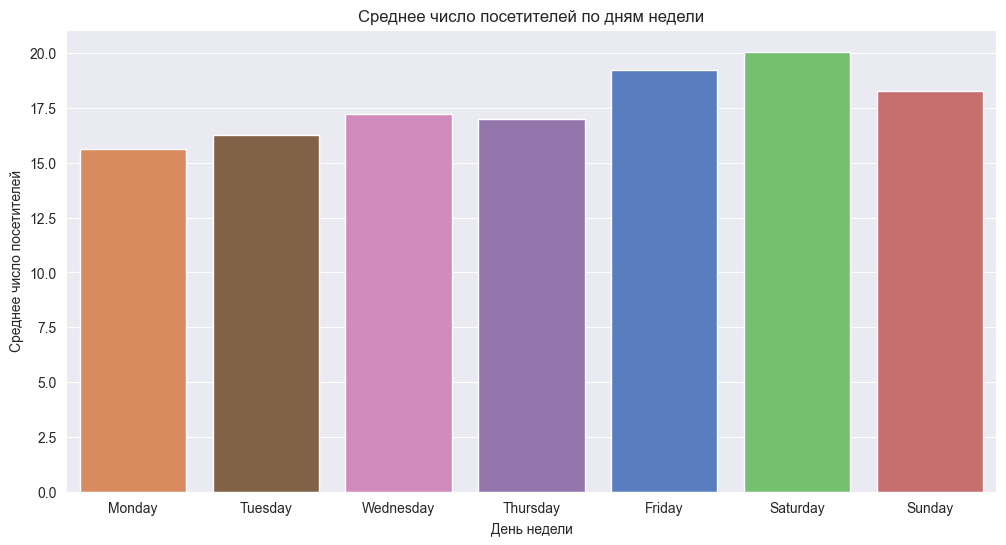

In [280]:

visitors_by_day = df.groupby('day_of_week')['visitors'].mean()

# Порядок дней недели
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=visitors_by_day.index, y=visitors_by_day.values, order=order_days, hue=visitors_by_day.index,
            palette="muted", legend=False)
plt.title('Среднее число посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее число посетителей')
plt.show()

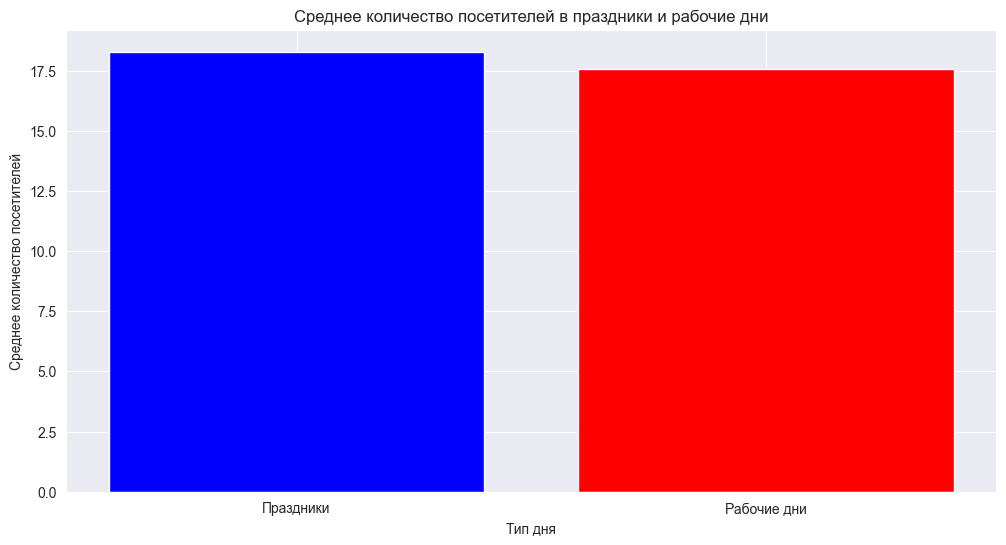

In [281]:
visitors_holiday = df[df['holiday_flg'] == 1]['visitors'].mean()
visitors_other_days = df[df['holiday_flg'] == 0]['visitors'].mean()
categories = ['Праздники', 'Рабочие дни']
visitors_means = [visitors_holiday, visitors_other_days]
plt.figure(figsize=(12, 6))
plt.bar(categories, visitors_means, color=['blue', 'red'])
plt.xlabel('Тип дня')
plt.ylabel('Среднее количество посетителей')
plt.title('Среднее количество посетителей в праздники и рабочие дни')
plt.grid(True)
plt.show()

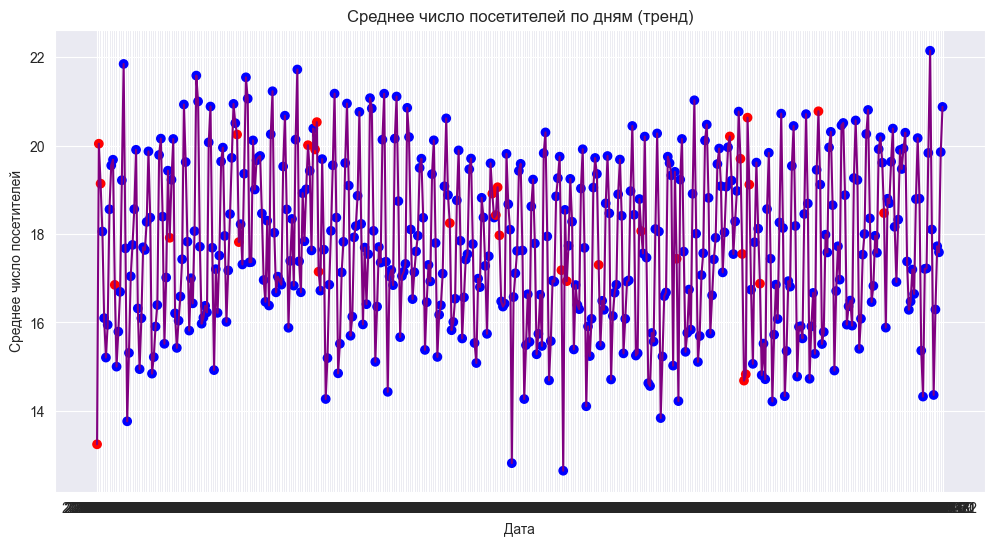

In [282]:

df['color'] = df['holiday_flg'].apply(lambda x: 'red' if x == 1 else 'blue')

# Группируем данные по дате и вычисляем среднее число посетителей
visitors_by_date = df.groupby('visit_date')['visitors'].mean()

# Создаем столбец с цветами для каждой даты
colors = df.groupby('visit_date')['color'].first()

# Построение графика
plt.figure(figsize=(12, 6))
plt.scatter(visitors_by_date.index, visitors_by_date.values, c=colors.values, marker='o')
plt.plot(visitors_by_date.index, visitors_by_date.values, color='purple')

plt.title('Среднее число посетителей по дням (тренд)')
plt.xlabel('Дата')
plt.ylabel('Среднее число посетителей')
plt.show()
del df['color']

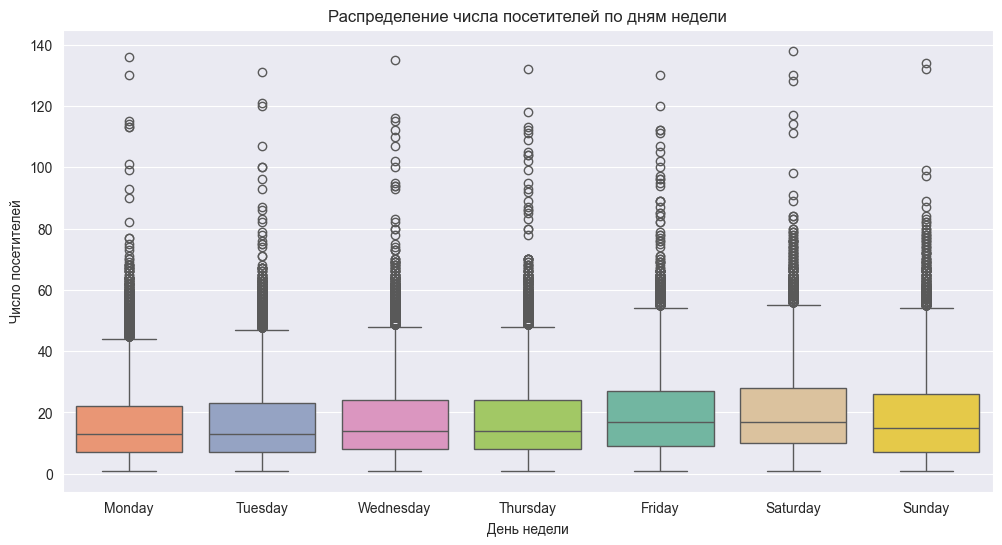

In [283]:

# Порядок дней недели
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Построение графика
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='visitors', data=df, order=order_days, hue='day_of_week', palette="Set2", legend=False)
plt.title('Распределение числа посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Число посетителей')
# plt.yscale('log')  # Логарифмическая шкала для удобства анализа
plt.show()

### Здесь наличие такого количесвтва точек - выбросов не проблема, потому что это отрисовываются значения для ресторанов у которых просто большие значения

C:\Users\Alexander\AppData\Local\Temp\ipykernel_28828\2643753854.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_restaurants.values, y=top_restaurants.index, palette='coolwarm')


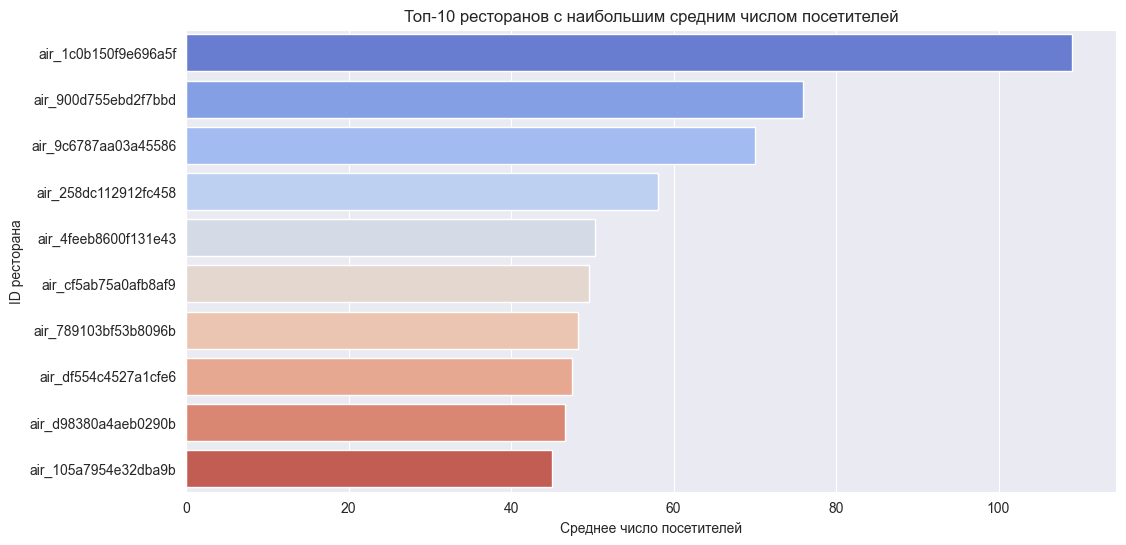

In [284]:

top_restaurants = df.groupby('air_store_id')['visitors'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_restaurants.values, y=top_restaurants.index, palette='coolwarm')
plt.title('Топ-10 ресторанов с наибольшим средним числом посетителей')
plt.xlabel('Среднее число посетителей')
plt.ylabel('ID ресторана')
plt.show()

In [285]:
df.reset_index(inplace=True)
df

,index,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,0,air_04341b588bde96cd,2016-01-01,10,Friday,1
1,194,air_04341b588bde96cd,2016-01-04,23,Monday,0
2,351,air_04341b588bde96cd,2016-01-05,35,Tuesday,0
3,582,air_04341b588bde96cd,2016-01-06,33,Wednesday,0
4,831,air_04341b588bde96cd,2016-01-07,52,Thursday,0
...,...,...,...,...,...,...
214991,248802,air_a17f0778617c76e2,2017-04-18,11,Tuesday,0
214992,249531,air_a17f0778617c76e2,2017-04-19,25,Wednesday,0
214993,250283,air_a17f0778617c76e2,2017-04-20,22,Thursday,0
214994,251052,air_a17f0778617c76e2,2017-04-21,49,Friday,0


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214996 entries, 0 to 214995
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         214996 non-null  int64 
 1   air_store_id  214996 non-null  object
 2   visit_date    214996 non-null  object
 3   visitors      214996 non-null  int64 
 4   day_of_week   214996 non-null  object
 5   holiday_flg   214996 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 9.8+ MB


In [287]:
df.columns

Index(['index', 'air_store_id', 'visit_date', 'visitors', 'day_of_week',
       'holiday_flg'],
      dtype='object')

In [288]:
for col in df.columns:
    print(col, df[col].isna().sum())

index 0
air_store_id 0
visit_date 0
visitors 0
day_of_week 0
holiday_flg 0


### Надо переписать признаки для дня недели и даты в виде понятном для программ

In [289]:
df['visit_date'] = pd.to_datetime(df['visit_date'])
df['day_of_week'] = df['day_of_week'].astype('category')
df['holiday_flg'] = df['holiday_flg'].astype('category')

In [290]:
df.columns

Index(['index', 'air_store_id', 'visit_date', 'visitors', 'day_of_week',
       'holiday_flg'],
      dtype='object')

In [291]:
df

,index,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,0,air_04341b588bde96cd,2016-01-01,10,Friday,1
1,194,air_04341b588bde96cd,2016-01-04,23,Monday,0
2,351,air_04341b588bde96cd,2016-01-05,35,Tuesday,0
3,582,air_04341b588bde96cd,2016-01-06,33,Wednesday,0
4,831,air_04341b588bde96cd,2016-01-07,52,Thursday,0
...,...,...,...,...,...,...
214991,248802,air_a17f0778617c76e2,2017-04-18,11,Tuesday,0
214992,249531,air_a17f0778617c76e2,2017-04-19,25,Wednesday,0
214993,250283,air_a17f0778617c76e2,2017-04-20,22,Thursday,0
214994,251052,air_a17f0778617c76e2,2017-04-21,49,Friday,0


In [292]:
from sklearn.preprocessing import OneHotEncoder

df['year'] = df['visit_date'].dt.year
df['month'] = df['visit_date'].dt.month
df['day'] = df['visit_date'].dt.day

encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_features = encoder.fit_transform(df[['day_of_week', 'holiday_flg']])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['day_of_week', 'holiday_flg']))


df = pd.concat([df.drop(columns=['day_of_week', 'holiday_flg', 'visit_date']), encoded_df], axis=1)
del df['holiday_flg_0']
print(df.head())

   index          air_store_id  visitors  year  month  day  \
0      0  air_04341b588bde96cd        10  2016      1    1   
1    194  air_04341b588bde96cd        23  2016      1    4   
2    351  air_04341b588bde96cd        35  2016      1    5   
3    582  air_04341b588bde96cd        33  2016      1    6   
4    831  air_04341b588bde96cd        52  2016      1    7   

   day_of_week_Friday  day_of_week_Monday  day_of_week_Saturday  \
0                 1.0                 0.0                   0.0   
1                 0.0                 1.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4                 0.0                 0.0                   0.0   

   day_of_week_Sunday  day_of_week_Thursday  day_of_week_Tuesday  \
0                 0.0                   0.0                  0.0   
1                 0.0                   0.0                  0.0   
2                 0.

In [293]:
df

,index,air_store_id,visitors,year,month,day,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_1
0,0,air_04341b588bde96cd,10,2016,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,194,air_04341b588bde96cd,23,2016,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,351,air_04341b588bde96cd,35,2016,1,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,582,air_04341b588bde96cd,33,2016,1,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,831,air_04341b588bde96cd,52,2016,1,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214991,248802,air_a17f0778617c76e2,11,2017,4,18,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
214992,249531,air_a17f0778617c76e2,25,2017,4,19,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
214993,250283,air_a17f0778617c76e2,22,2017,4,20,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
214994,251052,air_a17f0778617c76e2,49,2017,4,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Вот такой датасет получился. Сейчас буду его делить и пытаться обучить

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214996 entries, 0 to 214995
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  214996 non-null  int64  
 1   air_store_id           214996 non-null  object 
 2   visitors               214996 non-null  int64  
 3   year                   214996 non-null  int32  
 4   month                  214996 non-null  int32  
 5   day                    214996 non-null  int32  
 6   day_of_week_Friday     214996 non-null  float64
 7   day_of_week_Monday     214996 non-null  float64
 8   day_of_week_Saturday   214996 non-null  float64
 9   day_of_week_Sunday     214996 non-null  float64
 10  day_of_week_Thursday   214996 non-null  float64
 11  day_of_week_Tuesday    214996 non-null  float64
 12  day_of_week_Wednesday  214996 non-null  float64
 13  holiday_flg_1          214996 non-null  float64
dtypes: float64(8), int32(3), int64(2), o

In [295]:
df.describe()

,index,visitors,year,month,day,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_1
count,214996.000000,214996.000000,214996.000000,214996.000000,214996.000000,214996.000000,214996.000000,214996.000000,214996.000000,214996.000000,214996.000000,214996.000000,214996.000000
mean,126226.838299,17.605835,2016.310024,6.199860,15.497163,0.153101,0.137798,0.129463,0.109704,0.159989,0.155728,0.154217,0.046550
std,72338.993098,12.657722,0.462504,3.673984,8.659727,0.360085,0.344689,0.335712,0.312522,0.366597,0.362599,0.361157,0.210673
min,0.000000,1.000000,2016.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,64594.750000,8.000000,2016.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,125895.500000,15.000000,2016.000000,7.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,189053.250000,25.000000,2017.000000,10.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,252107.000000,138.000000,2017.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [296]:
for col in df.columns:
    print(col, df[col].isna().sum())

index 0
air_store_id 0
visitors 0
year 0
month 0
day 0
day_of_week_Friday 0
day_of_week_Monday 0
day_of_week_Saturday 0
day_of_week_Sunday 0
day_of_week_Thursday 0
day_of_week_Tuesday 0
day_of_week_Wednesday 0
holiday_flg_1 0


In [297]:
df.columns

Index(['index', 'air_store_id', 'visitors', 'year', 'month', 'day',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'holiday_flg_1'],
      dtype='object')

In [298]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

In [299]:
df_start = df.copy()
df = df.drop(columns=['index', 'air_store_id'])

# Разделяем данные на тренировочную и тестовую выборки (70% тренировочная, 30% тестовая)
X = df.drop(columns=['visitors'])
y = df['visitors']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Функция для кросс-валидации на основе скользящего окна
def rolling_cv(model, X, y, n_splits=5): 
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = []
    r2_scores = []
    max_errors = []
    mean_errors = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        errors = np.abs(y_test - y_pred)
        max_errors.append(np.max(errors))
        mean_errors.append(np.mean(errors))
    return np.mean(mse_scores), np.mean(r2_scores), np.mean(max_errors), np.mean(mean_errors)

# Линейная регрессия
linear_reg = LinearRegression()
mse_linear, r2_linear, max_error_linear, mean_error_linear = rolling_cv(linear_reg, X_train_scaled, y_train)
print(f"Linear Regression: MSE = {mse_linear}, R2 = {r2_linear}, Max Error = {max_error_linear}, Mean Error = {mean_error_linear}, Hyperparameters = []")

# Линейная регрессия с полиномиальными признаками
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
linear_reg_poly = LinearRegression()
mse_linear_poly, r2_linear_poly, max_error_linear_poly, mean_error_linear_poly = rolling_cv(linear_reg_poly, X_train_poly, y_train)
print(f"Linear Regression with Polynomial Features: MSE = {mse_linear_poly}, R2 = {r2_linear_poly}, Max Error = {max_error_linear_poly}, Mean Error = {mean_error_linear_poly}, Hyperparameters = []")

# Случайный лес
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_scaled, y_train)
best_rf = grid_search_rf.best_estimator_
mse_rf, r2_rf, max_error_rf, mean_error_rf = rolling_cv(best_rf, X_train_scaled, y_train)
print(f"Random Forest: MSE = {mse_rf}, R2 = {r2_rf}, Max Error = {max_error_rf}, Mean Error = {mean_error_rf}, Hyperparameters = {grid_search_rf.best_params_}")


Linear Regression: MSE = 157.89455910099565, R2 = 0.013948168842498433, Max Error = 109.94905113229272, Mean Error = 10.017414790516952, Hyperparameters = []
Linear Regression with Polynomial Features: MSE = 157.876583945678, R2 = 0.01406064221587402, Max Error = 109.09677734375, Mean Error = 10.014627829313602, Hyperparameters = []
Random Forest: MSE = 157.98415765969827, R2 = 0.013383677455268117, Max Error = 109.34246327640653, Mean Error = 10.018082700787275, Hyperparameters = {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}


### Проверено качество на тестовой выборке и теперь будет обучение на всем массиве данных

In [ ]:
df = df_start.copy()
df_start = df_start.drop(columns=['index', 'air_store_id'])
X = df_start.drop(columns=['visitors'])
y = df_start['visitors']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Функция для кросс-валидации на основе скользящего окна
def rolling_cv(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = []
    r2_scores = []
    max_errors = []
    mean_errors = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        errors = np.abs(y_test - y_pred)
        max_errors.append(np.max(errors))
        mean_errors.append(np.mean(errors))
    return np.mean(mse_scores), np.mean(r2_scores), np.mean(max_errors), np.mean(mean_errors)

# Линейная регрессия
linear_reg = LinearRegression()
# rolling_cv(linear_reg, X_scaled, y)  # Не выводим результаты
linear_reg.fit(X_scaled, y)

# Линейная регрессия с полиномиальными признаками
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
linear_reg_poly = LinearRegression()
# rolling_cv(linear_reg_poly, X_poly, y)  # Не выводим результаты
linear_reg_poly.fit(X_poly, y)

# Случайный лес
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_search_rf.fit(X_scaled, y)
best_rf = grid_search_rf.best_estimator_
# rolling_cv(best_rf, X_scaled, y)  # Не выводим результаты
best_rf.fit(X_scaled, y)

In [171]:
date_df

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [175]:
sample = pd.read_csv('recruit-restaurant-visitor-forecasting/sample_submission.csv')
sample[['air_store_id', 'visit_date']] = sample['id'].str.split('_', n=2, expand=True)[[1, 2]]

# Удаляем столбец id, так как он больше не нужен
sample = sample.drop(columns=['id'])

# Преобразуем visit_data в datetime
sample['visit_date'] = pd.to_datetime(sample['visit_date'])
date_df['visit_date'] = pd.to_datetime(date_df['visit_date'])
sample = pd.merge(sample, date_df, on='visit_date', how='inner')
sample['day_of_week'] = sample['day_of_week'].astype('category')
sample['holiday_flg'] = sample['holiday_flg'].astype('category')
sample['year'] = sample['visit_date'].dt.year
sample['month'] = sample['visit_date'].dt.month
sample['day'] = sample['visit_date'].dt.day
encoder = OneHotEncoder(sparse_output=False, drop='first')

encoded_features = encoder.fit_transform(sample[['day_of_week', 'holiday_flg']])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['day_of_week', 'holiday_flg']))

sample = pd.concat([sample.drop(columns=['day_of_week', 'holiday_flg', 'visit_date']), encoded_df], axis=1)

del sample['visitors','holiday_flg_0']

sample

,air_store_id,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_1,year,month,day
0,00a91d42b08b08d9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017,4,23
1,00a91d42b08b08d9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,4,24
2,00a91d42b08b08d9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2017,4,25
3,00a91d42b08b08d9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2017,4,26
4,00a91d42b08b08d9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017,4,27
...,...,...,...,...,...,...,...,...,...,...,...
32014,fff68b929994bfbd,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2017,5,27
32015,fff68b929994bfbd,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017,5,28
32016,fff68b929994bfbd,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,5,29
32017,fff68b929994bfbd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2017,5,30


## Предсказание

In [172]:
sample_scaled = scaler.transform(sample)

# Прогноз с использованием Linear Regression
sample['visitors_LR'] = linear_reg.predict(sample_scaled)
sample_poly = poly.transform(sample_scaled)
sample['visitors_PLR'] = linear_reg_poly.predict(sample_poly)
sample['visitors_RF'] = best_rf.predict(sample_scaled)
    
sample.to_csv('predicted_visitors.csv', index=False)
sample

,visitors,air_store_id,visit_date,day_of_week,holiday_flg
0,0,00a91d42b08b08d9,2017-04-23,Sunday,0
1,0,00a91d42b08b08d9,2017-04-24,Monday,0
2,0,00a91d42b08b08d9,2017-04-25,Tuesday,0
3,0,00a91d42b08b08d9,2017-04-26,Wednesday,0
4,0,00a91d42b08b08d9,2017-04-27,Thursday,0
...,...,...,...,...,...
32014,0,fff68b929994bfbd,2017-05-27,Saturday,0
32015,0,fff68b929994bfbd,2017-05-28,Sunday,0
32016,0,fff68b929994bfbd,2017-05-29,Monday,0
32017,0,fff68b929994bfbd,2017-05-30,Tuesday,0


In [168]:
df

,index,air_store_id,visitors,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_1,year,month,day
0,0,air_04341b588bde96cd,10,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2016,1,1
1,194,air_04341b588bde96cd,23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,1,4
2,351,air_04341b588bde96cd,35,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016,1,5
3,582,air_04341b588bde96cd,33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2016,1,6
4,831,air_04341b588bde96cd,52,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2016,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214991,248802,air_a17f0778617c76e2,11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2017,4,18
214992,249531,air_a17f0778617c76e2,25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2017,4,19
214993,250283,air_a17f0778617c76e2,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017,4,20
214994,251052,air_a17f0778617c76e2,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,4,21
